# Complete E-Commerce Data Analysis: Business First Approach

The purpose of this data analysis is to find key insights and derive meaning from it. We will try to derive some business impacting insights by trying to answer relevant questions like 
* Is company’s performance improving or degrading over time?
* What are some important trends visible in the sales data and insights?
* How can we measure our performance in terms of customer acquisition and building customer loyalty? 
* Can we take some initiatives based on the data to increase the sales? 
* Based on data can we avoid out of stock situations?
* What kind of customer do typically buy from us?

This dataset is orignally uploaded at https://archive.ics.uci.edu/ml/datasets/online+retail# 

Table of Contents 
> [Getting Started](#1)
>> [Importing Libraries](#1.1)<br>
>> [Reading Data](#1.2)
>>> [Data Description](#1.2.1)<br>

>> [Analysing -ve Quantity and -ve UnitPrice](#1.3)
>>> [Negative Quantity](#1.3.1) <br>
>>> [Negative Price](#1.3.2)

> [Preprocessing](#2)
>> [Duplicate Deletion](#2.1)<br>
>> [Analysing null Values](#2.2)

> [Feature Generation](#3)
>> [Creating Product StockCode Lookup](#3.1)<br>
>> [Feature Generation: Product Name](#3.2)<br>
>> [Feature Generation: Total Price](#3.3)<br>

> [Analysis](#4)
>> [Q. Is company’s performance improving or degrading over time?](#4.1)<br>
>> [Q. What are some important trends visible in the sales data and insights?](#4.2)<br>
>> [Regionwise Analysis](#4.2.1)<br>
>> [Q. How can we measure our performance in terms of customer acquisition and building customer loyalty?](#4.3)
>>> [RFM Analysis](#4.3.1)

>> [Q. Can we take some initiatives based on the data to increase the sales? ](#4.4)<br>
>> [Q. Based on data can we avoid out of stock situations?](#4.5)
>>> [Are there any products which are sold more during christmas season?](#4.5.1)

>> [Q.What kind of Customers are buying from us?](#4.6)

## Getting Started <a class="anchor" id="1"></a>
### Importing Libraries <a class="anchor" id="1.1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
from datetime import datetime
import plotly
plotly.offline.init_notebook_mode (connected = True)
import plotly.express as px
import matplotlib.pyplot as plt
import squarify
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA,PCA,TruncatedSVD
import spacy
import en_core_web_sm
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import calendar
# nlp = en_core_web_sm.load()
# !python -m spacy download en_core_web_md

In [2]:
### Copied from justfortherec's answer: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart


def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

### Reading Data <a class="anchor" id="1.2"></a>

Let's have sneak peek to the data

In [3]:
df = pd.read_csv("../input/ecommerce-data/data.csv",engine='python',parse_dates=['InvoiceDate'])
df_original = df.copy()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### Data Description <a class="anchor" id="1.2.1"></a>

This following information is taken from UCI Machine Learning Repository:<br>
*This is a transnational data set which contains all the transactions occurring between **01/12/2010 and 09/12/2011** for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.*


| Column | Description |
| --- | :-- |
| InvoiceNo | Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. **If this code starts with letter 'c', it indicates a cancellation.** |
| StockCode | Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. |
| Description | Product (item) name. Nominal. |
| Quantity | The quantities of each product (item) per transaction. Numeric. |
| InvoiceDate | Invice Date and time. Numeric, the day and time when each transaction was generated. |
| UnitPrice | Numeric, Product price per unit in sterling. |
| CustomerID | Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. |
| Country | Country name. Nominal, the name of the country where each customer resides. |



In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


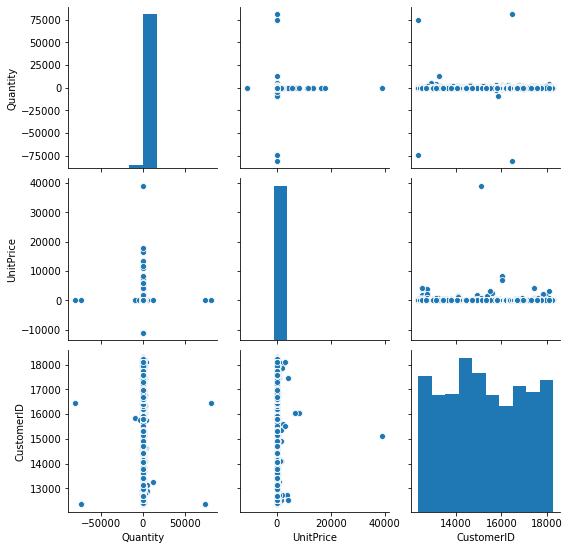

In [5]:
sns.pairplot(df)

It should be noted that there are -ve values in both ```UnitPrice``` and ```Quantity```. Is it for cancelled orders?

### Analysing -ve Quantity and -ve UnitPrice <a class="anchor" id="1.3"></a>
#### Negative Quantity <a class="anchor" id="1.3.1"></a>

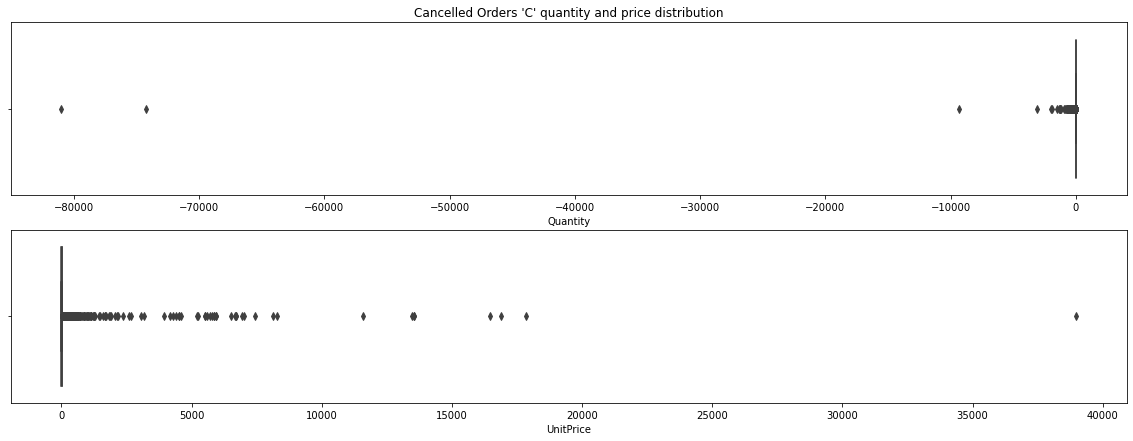

In [6]:
fig,ax = plt.subplots(nrows=2,figsize=(20,7))
sns.boxplot(df[(df['InvoiceNo'].str[0]=='c')|(df['InvoiceNo'].str[0]=='C')]['Quantity'],ax=ax[0])
sns.boxplot(df[(df['InvoiceNo'].str[0]=='c')|(df['InvoiceNo'].str[0]=='C')]['UnitPrice'],ax=ax[1])
ax[0].title.set_text("Cancelled Orders 'C' quantity and price distribution")

In [7]:
neg_qty = df[df["Quantity"]<0]
neg_qty_without_C = neg_qty[neg_qty["InvoiceNo"].str[0]!="C"]
print("Negative Qty without 'C' in InvoiceNo \n Unit Prices: {} \t CustomerIDs: {}".format(neg_qty_without_C["UnitPrice"].unique(),neg_qty_without_C["CustomerID"].unique()))

Negative Qty without 'C' in InvoiceNo 
 Unit Prices: [0.] 	 CustomerIDs: [nan]


We don't need to bother for the negative quantity without C in invoice number as their unit price 0 only. They won't effect the calculations later on. These entries have no CustomerID assoiciated with them.<br><br>
Do all -ve Quantity have 'C' initiated ```InvoiceNo```? <br>
'C' is said to be denoting cancelled orders and hence have -ve quantity. But we need to analyse it to be sure.

#### **HYPOTHESIS: Rows with -ve quantities mean that the order was previously ordered and cancelled later on.**
If this hypothesis is true, then for majority of negative quantity orders, there must exist an entry which follows following condition (Why majority? Because for some initial months because of data cut conditions won't satisfy):<br>
1. CustomerID (if exists) must match
2. Quantity ordered <= Quantity Cancelled
3. Order date must before Order cancelled date

In [8]:
def check_hypothesis_cancelled_order(df):
    failed = 0
    passed = 0
    neg_qty = df[df["Quantity"]<0]
    pos_qty = df[~df["Quantity"]<0]
    for ind in neg_qty.index:
        if(neg_qty['CustomerID'][ind]):
            p = pos_qty[
                (pos_qty['CustomerID'] == neg_qty['CustomerID'][ind])&
                (pos_qty['Quantity'] <= abs(neg_qty['Quantity'][ind]))&
                ((pos_qty['InvoiceDate'] - neg_qty['InvoiceDate'][ind]).dt.total_seconds()>=0)
            ]
            if(len(p)==0):
                failed+=1
            else:
                passed+=1
    if(failed>passed):
        print("Hypothesis Rejected!")
        print("Failed Counts:"+str(failed)+" Passed Counts:"+str(passed))
        print("Approximately "+str(int(failed/(failed + passed)*100)) + "% rows didn't satisfy the condition")
    else:
        print("Hypothesis Accepted")
        print("Failed Counts:"+str(failed)+" Passed Counts:"+str(passed))
        print("Approximately "+str(int(passed/(failed + passed)*100)) + "% rows satisfy the condition")
            

In [9]:
check_hypothesis_cancelled_order(df)

Hypothesis Accepted
Failed Counts:4665 Passed Counts:5959
Approximately 56% rows satisfy the condition


Since, 56% rows satisfy our condition hence, we can surely say that -ve quantity entries are for some previous order cancellation 

#### Negative Pricing <a class="anchor" id="1.3.2"></a>

In [10]:
neg_price = df[df["UnitPrice"]<0]
neg_price

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


## Preprocessing <a class="anchor" id="2"></a>
### Duplicate Deletion <a class="anchor" id="2.1"></a>

In [11]:
df.drop_duplicates(inplace=True)

### Analysing the *null* values <a class="anchor" id="2.2"></a>

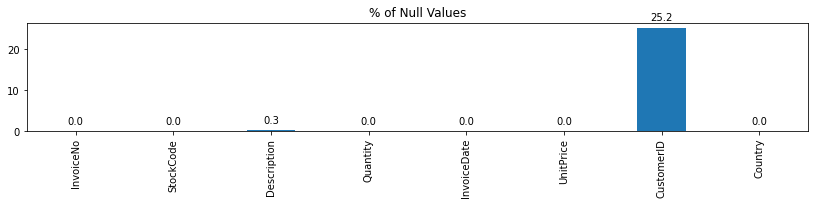

In [12]:
fig,ax = plt.subplots(figsize=(14,2))
((df.isnull().sum() / len(df))*100).plot.bar(ax=ax)
add_value_labels(ax)
ax.set_title('% of Null Values')
plt.show()

We can see there are missing values in ```Description``` and ```CustomerID```. <br>
**~25%** of values missing in ```CustomerID``` and **~0.3%** values are missing in ```Description```.<br>
We cannot do anything for ```CustomerID```, but let's check what can we do for ```Description```.

First, it is important to check whether if each ```StockCode``` has a unique ```Description```

In [13]:
x = pd.DataFrame(df.groupby("StockCode")["Description"].value_counts())
y = x.droplevel(level=1).index
y = y[y.duplicated()]
test = df[["StockCode","Description"]]
test = test.drop_duplicates()
test1 = test[test["StockCode"].isin(y)]
test2 = pd.DataFrame(test1.groupby("StockCode")["Description"].value_counts())
test2.head(10)

Description
StockCode Description                                     
10080     GROOVY CACTUS INFLATABLE                       1
          check                                          1
10133     COLOURING PENCILS BROWN TUBE                   1
          damaged                                        1
15058A    BLUE POLKADOT GARDEN PARASOL                   1
          wet/rusty                                      1
15058C    ICE CREAM DESIGN GARDEN PARASOL                1
          wet/rusty                                      1
16008     SMALL FOLDING SCISSOR(POINTED EDGE)            1
          check                                          1

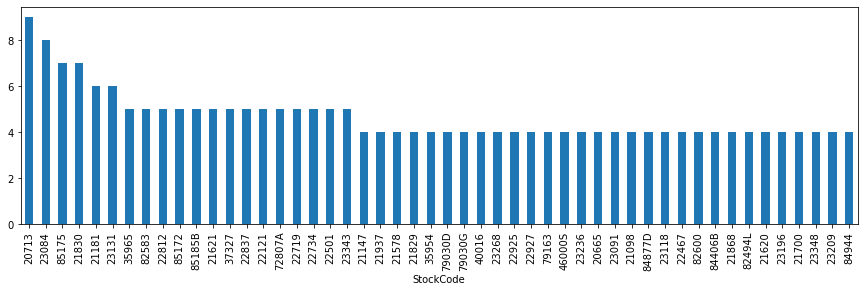

In [14]:
fig, ax = plt.subplots(figsize=(15,4))
grouped = df.groupby("StockCode")['Description'].unique()
grouped_counts = grouped.apply(lambda x: len(x)).sort_values(ascending=False)
grouped_counts.head(50).plot.bar(ax=ax)

We can see that there are products which have varied ```Description``` but belong to same ```StockCode``` For example, for ```StockCode```= 20713, there are 8 unique descriptions (9 including null)

In [15]:
df[df["StockCode"]=="20713"]["Description"].unique()

array(['JUMBO BAG OWLS', nan, 'wrongly marked. 23343 in box',
       'wrongly coded-23343', 'found', 'Found', 'wrongly marked 23343',
       'Marked as 23343', 'wrongly coded 23343'], dtype=object)

## Feature Generation <a class="anchor" id="3"></a>
### Creating Product StockCode Lookup <a class="anchor" id="3.1"></a>

We can see Description not only tells what the product is but in some cases it is either corrupted by vague values or describes the condition of product (for eg. "wet/rusty"). We can create a product lookup which can tell us a good idea what product a specific ```StockCode``` indicates to.

In [16]:
# LOGIC: Description with max upper case letters = Product Name

def get_product_name(x):
    max_upper_count = 0
    product_name = ''
    for i in x:
        if(i==i):  #To Check for NaN
            count = 0
            for letter in i:
                if(letter.isupper()):
                    count = count+1
            if count>max_upper_count:
                max_upper_count = count
                product_name = i
    return product_name


In [17]:
grouped = df.groupby("StockCode")['Description'].unique()
lookup = grouped.apply(get_product_name)
# lookup.to_excel('lookup_product_stockCode.xlsx')

### Feature Generation: Product Name <a class="anchor" id="3.2"></a>

In [18]:
df = df.join(other=lookup, on='StockCode', how='left', rsuffix='ProductName')
df = df.rename(columns={'DescriptionProductName':'ProductName'})

In [19]:
# GETTING SIMILARITY BETWEEN THE Description AND ProductName
# !pip install jellyfish
# import jellyfish
from difflib import SequenceMatcher

des = df['Description']
prod = df['ProductName']
dist = []
for d,p in zip(des, prod):
    try:
        dist.append(SequenceMatcher(None,d,p).ratio())
#         dist.append(float(jellyfish.damerau_levenshtein_distance(d,p)))
    except:
        dist.append(0)
        

In [20]:
df['dist'] = dist
df[(df['dist']<0.3)&(df['dist']!=0)][['StockCode','Description','ProductName','dist']]

,StockCode,Description,ProductName,dist
22296,46000S,Dotcom sales,POLYESTER FILLER PAD 40x40cm,0.150000
22297,46000M,Dotcom sales,POLYESTER FILLER PAD 45x45cm,0.150000
30555,22734,amazon sales,SET OF 6 RIBBONS VINTAGE CHRISTMAS,0.043478
39047,85135B,Found,BLUE DRAGONFLY HELICOPTER,0.066667
42564,22501,reverse 21/5/10 adjustment,PICNIC BASKET WICKER LARGE,0.076923
...,...,...,...,...
524369,23406,CHECK,HOME SWEET HOME KEY HOLDER,0.193548
524622,22927,Amazon,GREEN GIANT GARDEN THERMOMETER,0.055556
532724,22481,wet boxes,BLACK TEA TOWEL CLASSIC DESIGN,0.051282
535329,21693,mixed up,SMALL HAMMERED SILVER CANDLEPOT,0.050000


### Feature Generation: Total Price <a class="anchor" id="3.3"></a>

In [21]:
df["TotalPrice"] = df["UnitPrice"] * df["Quantity"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



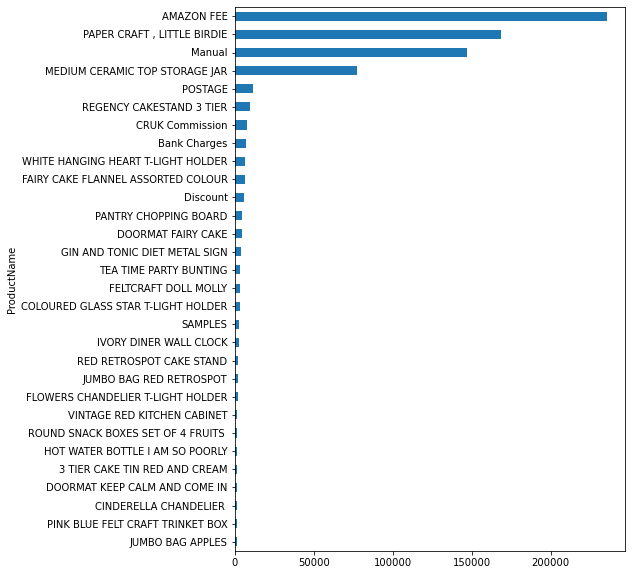

In [22]:
fig, ax = plt.subplots(figsize=(7,10))
neg_qty = df[df["Quantity"]<0]
neg_qty["TotalPrice"] = abs(neg_qty["TotalPrice"])
x = neg_qty[["ProductName","TotalPrice"]]
x.groupby("ProductName")["TotalPrice"].sum().sort_values(ascending=True).tail(30).plot.barh(ax=ax)

We can see `AMAZON FEE`, `Manual`, `Bank Charges`, `Postage` are some of the main contributors for negative priced entries

#### Removing 'C' Products

In [23]:
cancelled_df = df[df['InvoiceNo'].str[0]=='C']
df = df[~(df['InvoiceNo'].str[0]=='C')]
cancelled_df = cancelled_df.reset_index(drop=True)

## Analysis <a class="anchor" id="4"></a>
Now as we have cleaned our dataset and also generated required features, we are good to go for analysing our actual business problems
### Q. Is company’s performance improving or degrading over time? <a class="anchor" id="4.1"></a>
Company’s performance can be measured in many terms. Here, we will be analysing the performance by:

* Growth in Revenue by Sales

* Growth in Sales Quantity

* Growth in Customer Base 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



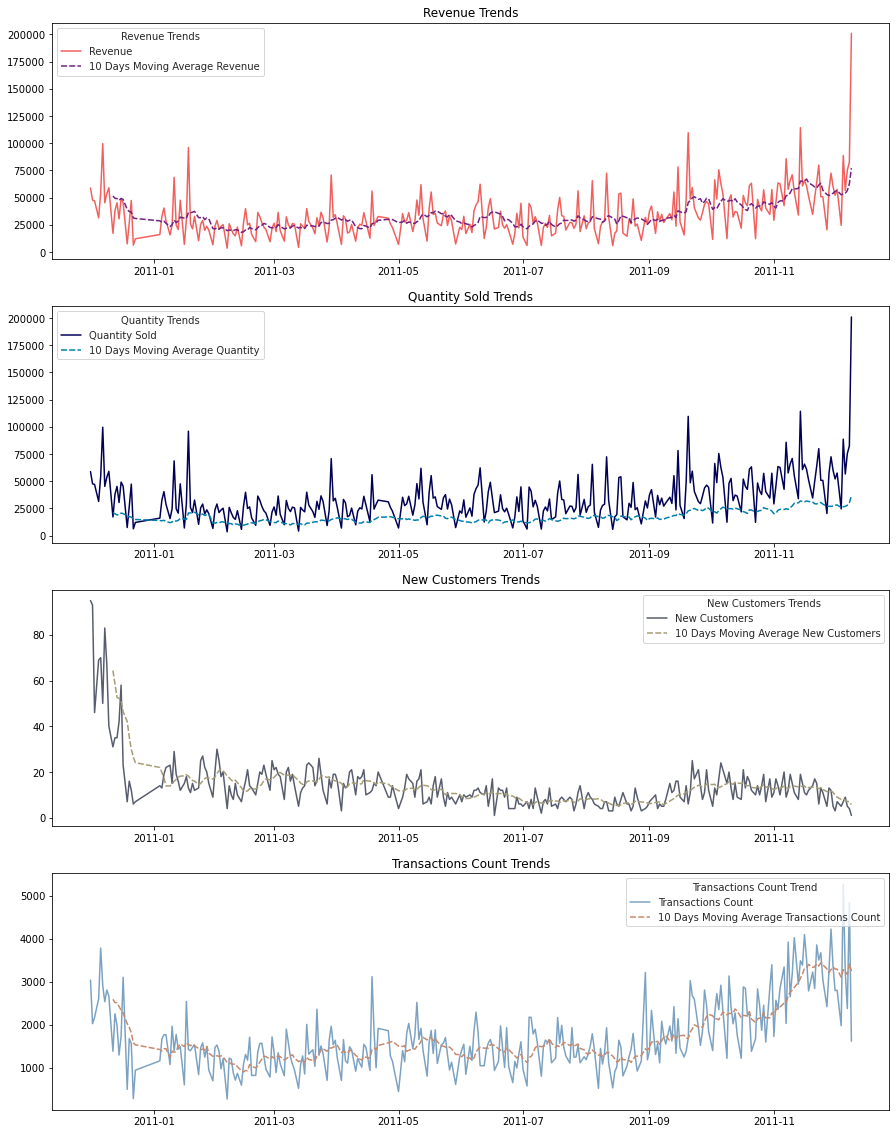

In [24]:
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,20))
rev = df[df['TotalPrice']>=0]
rev['TransactionsCount'] = 1
rev = rev.groupby(rev['InvoiceDate'].dt.date).agg({'TotalPrice':'sum',
                                                  'Quantity': 'sum',
                                                  'CustomerID': 'count',
                                                  'TransactionsCount':'sum'})
rev['10 Days Moving Average Revenue'] = rev['TotalPrice'].rolling(10).mean()
rev['10 Days Moving Average Quantity'] = rev['Quantity'].rolling(10).mean()
rev['10 Days Moving Transactions Count'] = rev['TransactionsCount'].rolling(10).mean()
cust = df.groupby('CustomerID').first().reset_index()[['CustomerID','InvoiceDate']]
cust = cust.groupby(cust.InvoiceDate.dt.date).agg({'CustomerID':'count'})
cust['10 Days Moving Average Quantity'] = cust['CustomerID'].rolling(10).mean()

sns.set_style("whitegrid")
sns.lineplot(data=rev[['TotalPrice','10 Days Moving Average Revenue']], palette='magma_r', linewidth=1.5, ax=ax[0],legend=False)
ax[0].legend(title='Revenue Trends', loc='upper left', labels=['Revenue', '10 Days Moving Average Revenue'])
ax[0].title.set_text('Revenue Trends')
ax[0].set_xlabel('')

sns.lineplot(data=rev[['TotalPrice','10 Days Moving Average Quantity']], palette='ocean', linewidth=1.5, ax=ax[1])
ax[1].legend(title='Quantity Trends', loc='upper left', labels=['Quantity Sold', '10 Days Moving Average Quantity'])
ax[1].title.set_text('Quantity Sold Trends')
ax[1].set_xlabel('')

sns.lineplot(data=cust, palette='cividis', linewidth=1.5, ax=ax[2])
ax[2].legend(title='New Customers Trends', loc='upper right', labels=['New Customers', '10 Days Moving Average New Customers'])
ax[2].title.set_text('New Customers Trends')
ax[2].set_xlabel('')

sns.lineplot(data=rev[['TransactionsCount','10 Days Moving Transactions Count']], palette='twilight_shifted', linewidth=1.5, ax=ax[3])
ax[3].legend(title='Transactions Count Trend', loc='upper right', labels=['Transactions Count', '10 Days Moving Average Transactions Count'])
ax[3].title.set_text('Transactions Count Trends')
ax[3].set_xlabel('')

plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



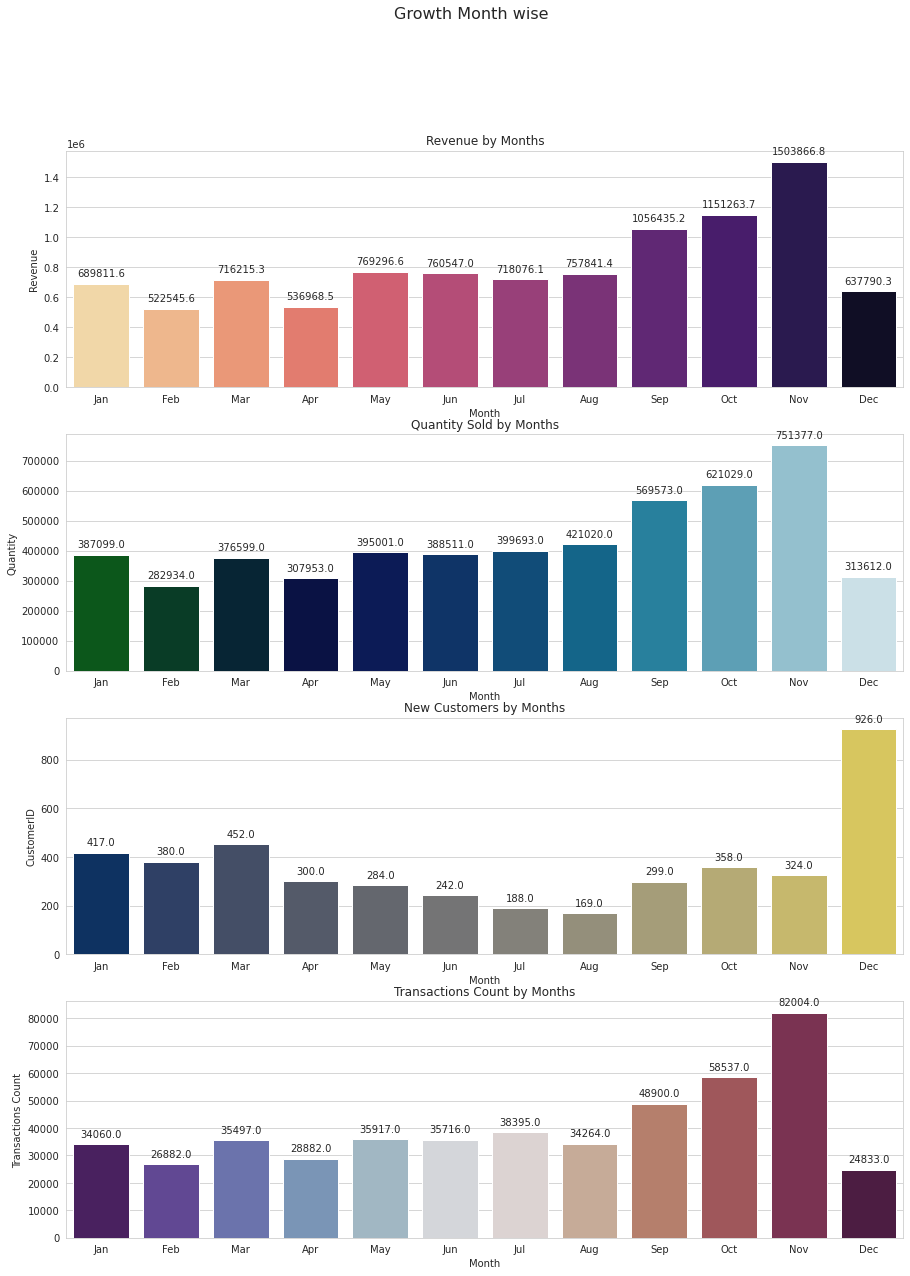

In [25]:
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,20))
rev = df[(df['TotalPrice']>0)&(df['InvoiceDate'].dt.year==2011)]
rev['Transactions Count'] = 1
rev = rev.groupby(rev['InvoiceDate'].dt.month).agg({'TotalPrice':'sum',
                                                  'Quantity': 'sum',
                                                  'CustomerID': 'count',
                                                'Transactions Count':'sum'})
rev = rev.reset_index()
rev['Month'] = rev['InvoiceDate'].apply(lambda x: calendar.month_abbr[x])
rev = rev.rename({'TotalPrice':'Revenue'},axis=1)
cust = df.groupby('CustomerID').first().reset_index()[['CustomerID','InvoiceDate']]
cust = cust.groupby(cust.InvoiceDate.dt.month).agg({'CustomerID':'count'})
cust = cust.reset_index()
cust['Month'] = cust['InvoiceDate'].apply(lambda x: calendar.month_abbr[x])


sns.set_style("whitegrid")
sns.barplot(data=rev, x=rev.Month, y='Revenue', palette='magma_r', ax=ax[0])
ax[0].title.set_text('Revenue by Months')
add_value_labels(ax[0])

sns.barplot(data=rev, x=rev.Month, y='Quantity',  palette='ocean', ax=ax[1])
ax[1].title.set_text('Quantity Sold by Months')
add_value_labels(ax[1])

sns.barplot(data=cust, x=cust.Month, y='CustomerID',  palette='cividis', ax=ax[2])
ax[2].title.set_text('New Customers by Months')
fig.suptitle('Growth Month wise',fontsize=16)
add_value_labels(ax[2])

sns.barplot(data=rev, x=rev.Month, y='Transactions Count',  palette='twilight_shifted', ax=ax[3])
ax[3].title.set_text('Transactions Count by Months')
fig.suptitle('Growth Month wise',fontsize=16)
add_value_labels(ax[3])

plt.show()

**Inferences**

* It seems that company’s performance is improving in terms of revenue and sales, but as we are provided with just one year of data, it is hard to claim this for sure


* There might be a seasonal rise during the end of the year.


* In terms of new customer acquisition,  we can see a clear downward slope. Though, it can be explained by the fact that, with growing customer base, it is difficult to get more new customers. 


* We can compare December sales for 2010 and 2011 to get an insight


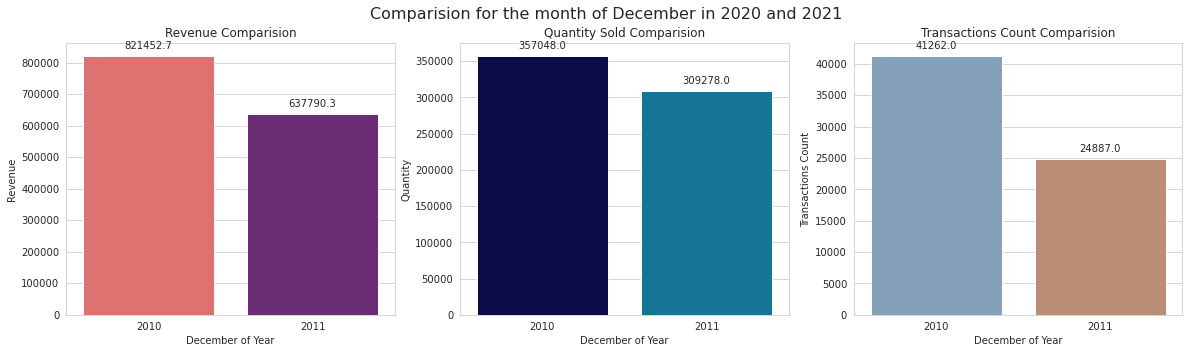

In [26]:
sales_comp = df[(df['InvoiceDate'].dt.month==12)&(df['TotalPrice']>=0)][['InvoiceDate','TotalPrice','Quantity']]
sales_comp['Transactions Count'] = 1
sales_comp = sales_comp.groupby(sales_comp['InvoiceDate'].dt.year)[['TotalPrice','Quantity','Transactions Count']].sum()
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,5))

sns.set_style("whitegrid")
sns.barplot(data=sales_comp, x=sales_comp.index, y='TotalPrice', palette='magma_r', ax=ax[0])
ax[0].title.set_text('Revenue Comparision')
ax[0].set_ylabel('Revenue')
ax[0].set_xlabel('December of Year')
add_value_labels(ax[0])

sns.barplot(data=sales_comp, x=sales_comp.index, y='Quantity',  palette='ocean', ax=ax[1])
ax[1].title.set_text('Quantity Sold Comparision')
add_value_labels(ax[1])
ax[1].set_xlabel('December of Year')

sns.barplot(data=sales_comp, x=sales_comp.index, y='Transactions Count',  palette='twilight_shifted', ax=ax[2])
ax[2].title.set_text('Transactions Count Comparision')
add_value_labels(ax[2])
ax[2].set_xlabel('December of Year')

fig.suptitle('Comparision for the month of December in 2020 and 2021',fontsize=16)

plt.show()

In [27]:
print("Sales Revenue Difference: {:2.2f}% decline in revenue from 2010 \nSales Quantity Difference: {:2.2f}% decline in quantity from 2010".format(
((sales_comp['TotalPrice'][2010] - sales_comp['TotalPrice'][2011]) / sales_comp['TotalPrice'][2010])*100,
    ((sales_comp['Quantity'][2010] - sales_comp['Quantity'][2011]) / sales_comp['Quantity'][2010])*100
))
    

Sales Revenue Difference: 22.36% decline in revenue from 2010 
Sales Quantity Difference: 13.38% decline in quantity from 2010


* Here, we can see that company’s revenue by sales is decreased from 2010 by **22.4%**, suggesting that company’s performance is degrading.
* We get a similar picture in sales quantity as well. A net decrease of **13.4%**  in Sales quantity.


### Q.What are some important trends visible in the sales data and insights? <a class="anchor" id="4.2"></a>

* After clustering the data in different forms, many interesting  purchasing patterns emerged. 
* Trends can be better known through the purchasing pattern of the customers.
* We can prose certain hypothesis to check the purchasing pattern, like

> Do customers tend to buy more on certain weekday? <br>
> Do customers buy more at the start of the month?<br>
> Do customers tend to buy more at a specific hour of the day?<br>


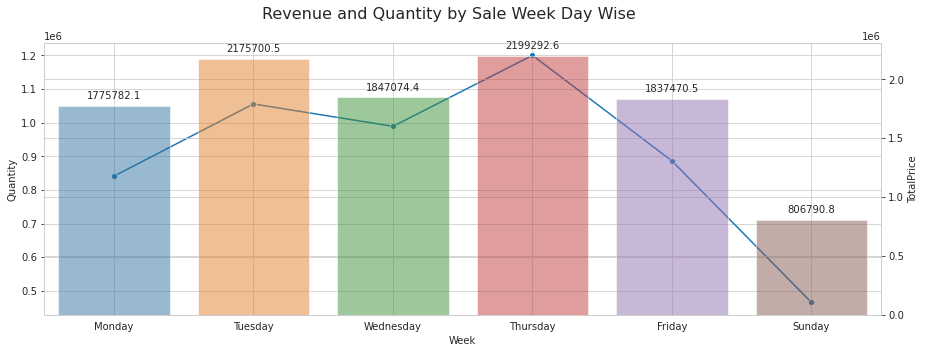

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,5))
sns.set_style("whitegrid")

week = df[df['TotalPrice']>=0][['InvoiceDate','TotalPrice','Quantity']]
week = week.groupby(week['InvoiceDate'].dt.weekday)[['TotalPrice','Quantity']].sum()
week = week.reset_index()
week['Week'] = week['InvoiceDate'].apply(lambda x: calendar.day_name[x])

sns.lineplot(data = week, x=week.Week, y='Quantity', marker='o', sort = False, ax=ax)
ax2 = ax.twinx()
sns.barplot(data = week, x=week.Week, y='TotalPrice', alpha=0.5, ax=ax2)
fig.suptitle('Revenue and Quantity by Sale Week Day Wise',fontsize=16)
add_value_labels(ax2)

plt.show()

* It is interesting to note that Thursdays have the maximum sale by volume and as well as revenue. 
* Also, there are no transactions done on Saturdays. It is safe to assume that the store is closed on Saturdays.
* Nearly, 42% of total sale is done on Thursdays and Tuesdays 


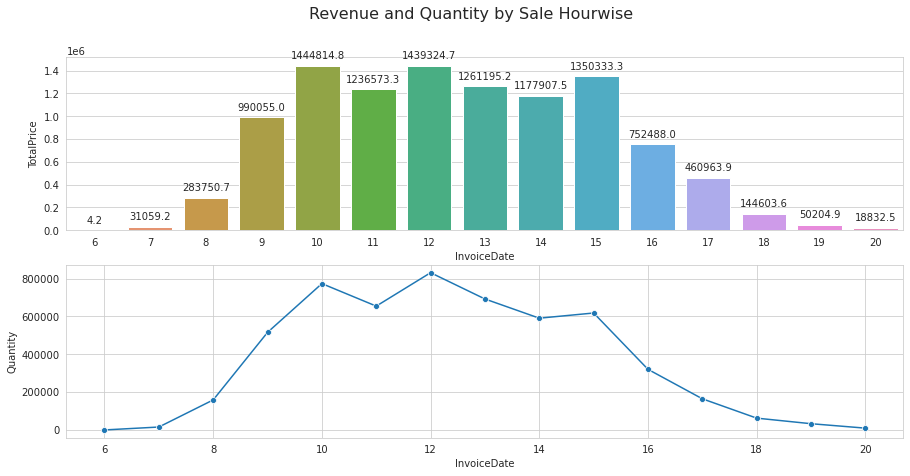

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))
sns.set_style("whitegrid")

day = df[df['TotalPrice']>=0][['InvoiceDate','TotalPrice','Quantity']]
day = day.groupby(day['InvoiceDate'].dt.hour)[['TotalPrice','Quantity']].sum()

sns.barplot(data = day, x=day.index, y='TotalPrice', alpha=1, ax=ax[0])
sns.lineplot(data = day, x=day.index, y='Quantity', marker='o', sort = False, ax=ax[1])
fig.suptitle('Revenue and Quantity by Sale Hourwise',fontsize=16)
add_value_labels(ax[0])
plt.show()

* We can see that the customers do tend to buy between 9:00 hrs - 13:00 hrs. Infact, ~51 % of the sales by revenue is done in these hours

* Also, there are no transactions are done before 6:00 hrs and after 20:00 hrs. It can be assumed that the store usually opens for 14 hours between 6:00 hrs and 20:00 hrs.


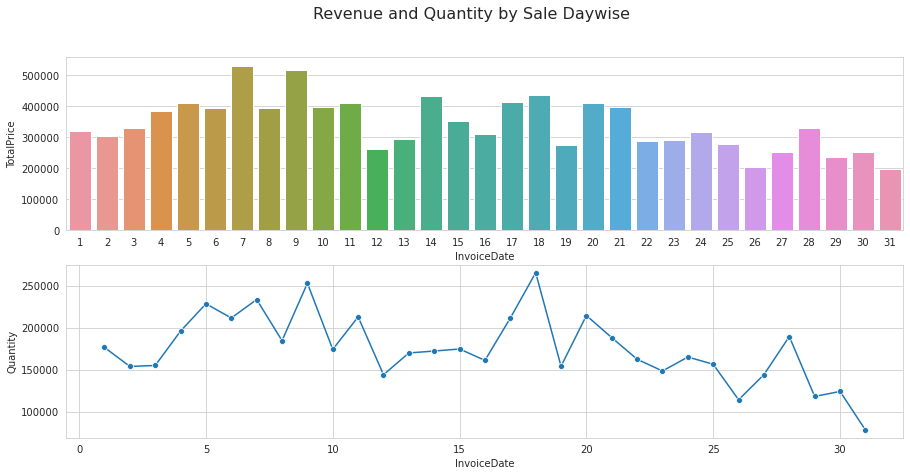

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))
sns.set_style("whitegrid")

date = df[df['TotalPrice']>=0][['InvoiceDate','TotalPrice','Quantity']]
date = date.groupby(date['InvoiceDate'].dt.day)[['TotalPrice','Quantity']].sum()

sns.barplot(data = date, x=date.index, y='TotalPrice', alpha=1, ax=ax[0])
sns.lineplot(data = date, x=date.index, y='Quantity', marker='o', sort = False, ax=ax[1])
fig.suptitle('Revenue and Quantity by Sale Daywise',fontsize=16)

plt.show()

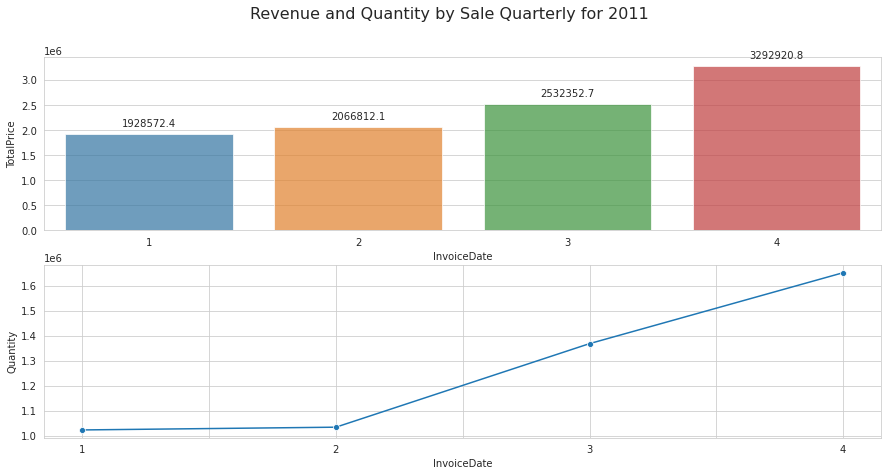

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))
sns.set_style("whitegrid")

q = df[(df['TotalPrice']>=0)&(df['InvoiceDate'].dt.year==2011)][['InvoiceDate','TotalPrice','Quantity']]
q = q.groupby(q['InvoiceDate'].dt.quarter)[['TotalPrice','Quantity']].sum()

sns.barplot(data = q, x=q.index, y='TotalPrice', alpha=0.7, ax=ax[0])
sns.lineplot(data = q, x=q.index, y='Quantity', marker='o', sort = False, ax=ax[1])
fig.suptitle('Revenue and Quantity by Sale Quarterly for 2011',fontsize=16)
add_value_labels(ax[0])
ax[1].set_xticklabels(['',1,'',2,'',3,'',4])
plt.show()

* It is evident that there is increase in sales by both volume and revenue in the fourth quarter of the year 2011.
* There is major sale in the month of November and December.
* It could be because of Holiday season.

### Regionwise Analysis <a class="anchor" id="4.2.1"></a>

In [32]:
reg = df[df['TotalPrice']>=0].groupby('Country').agg({'TotalPrice':'sum',
                                                  'Quantity': 'sum',
                                                  'CustomerID': 'count'})

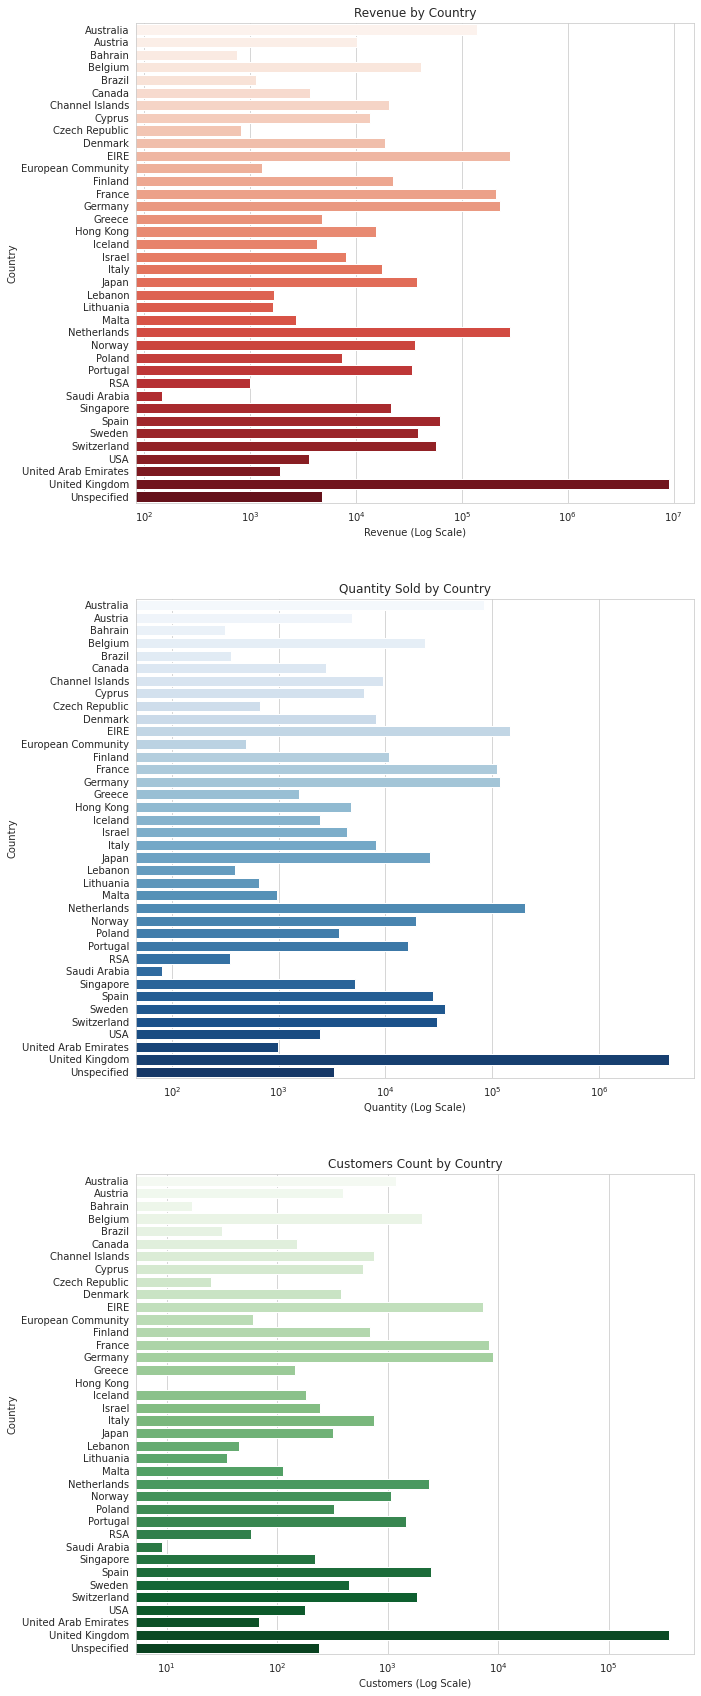

In [33]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,30))
g1 = sns.barplot(x=reg['TotalPrice'], y=reg.index, alpha=1, ax=ax[0],palette='Reds', orient='h')
g2 = sns.barplot(x=reg['Quantity'], y=reg.index, alpha=1, ax=ax[1], palette='Blues',orient='h')
g3 = sns.barplot(x=reg['CustomerID'], y=reg.index, alpha=1, ax=ax[2], palette='Greens', orient='h')
ax[2].title.set_text('Customers Count by Country')
ax[2].set_xlabel("Customers (Log Scale)")
ax[1].title.set_text('Quantity Sold by Country')
ax[1].set_xlabel("Quantity (Log Scale)")
ax[0].title.set_text('Revenue by Country')
ax[0].set_xlabel("Revenue (Log Scale)")
g1.set_xscale("log")
g2.set_xscale("log")
g3.set_xscale("log")
plt.show()


* Major sales is been done from UK (~85%). 
* Almost 95% of all the transactions occurring are from Europe 

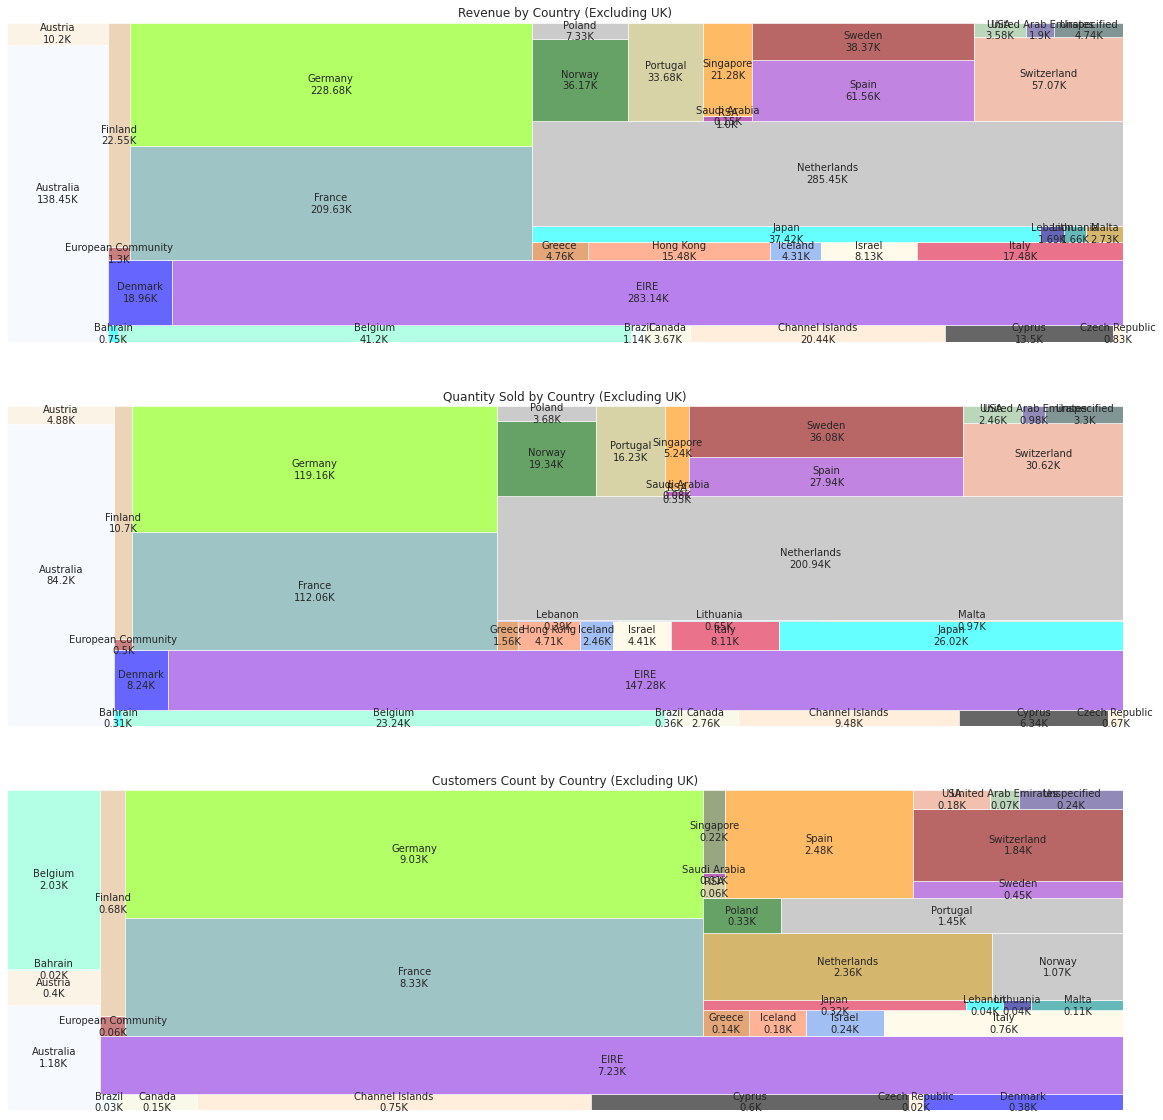

In [34]:
reg = reg[reg.index!='United Kingdom']
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,20))
# Change color
squarify.plot(sizes=reg['TotalPrice'], label=[str(x)+'\n'+str(y)+'K' for x,y in zip(reg.index,(reg['TotalPrice']/1000).round(2))], alpha=.6, ax=ax[0], color=mcolors.CSS4_COLORS )
ax[0].title.set_text('Revenue by Country (Excluding UK)')
squarify.plot(sizes=reg['Quantity'], label=[str(x)+'\n'+str(y)+'K' for x,y in zip(reg.index,(reg['Quantity']/1000).round(2))], alpha=.6, ax=ax[1], color=mcolors.CSS4_COLORS )
ax[1].title.set_text('Quantity Sold by Country (Excluding UK)')
r1 = reg[reg['CustomerID']!=0]
squarify.plot(sizes=r1['CustomerID'], label=[str(x)+'\n'+str(y)+'K' for x,y in zip(r1.index,(r1['CustomerID']/1000).round(2))], alpha=.6, ax=ax[2], color=mcolors.CSS4_COLORS )
ax[2].title.set_text('Customers Count by Country (Excluding UK)')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

In [35]:
## Copied this beautiful piece of code from fabiendaniel's notebook
## https://www.kaggle.com/fabiendaniel/customer-segmentation


import plotly.graph_objs as go
import warnings
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order no.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

### Q. How can we measure our performance in terms of customer acquisition and building customer loyalty? <a class="anchor" id="4.3"></a>

#### RFM Analysis <a class="anchor" id="4.3.1"></a>

Used to segregate the customers based on behaviors

RFM helps in segregating:
* the more recent the purchase, the more responsive the customer is to promotions
* the more frequently the customer buys, the more engaged and satisfied they are
* monetary value differentiates heavy spenders from low-value purchasers


In [36]:
lastdate = datetime(2012,1,1)
cleaned_dataset = df[df['TotalPrice']>=0]
recent = (lastdate - cleaned_dataset.groupby("CustomerID")["InvoiceDate"].last()).dt.days
frequent = cleaned_dataset.groupby("CustomerID")["InvoiceDate"].count()
monetary = cleaned_dataset.groupby("CustomerID")["TotalPrice"].sum()

In [37]:
recent_quantile = recent.quantile(q=[0.25,0.5,0.75])
recent_quantile

0.25     39.0
0.50     72.0
0.75    163.5
Name: InvoiceDate, dtype: float64

In [38]:
frequent_quantile = frequent.quantile(q=[0.25,0.5,0.75])
frequent_quantile

0.25    17.0
0.50    41.0
0.75    98.0
Name: InvoiceDate, dtype: float64

In [39]:
monetary_quantile = monetary.quantile(q=[0.25,0.5,0.75])
monetary_quantile

0.25     306.455
0.50     668.560
0.75    1660.315
Name: TotalPrice, dtype: float64

In [40]:
rfm = pd.DataFrame(data=[recent,frequent,monetary])
rfm = rfm.transpose()
rfm.columns = ["recent","frequent","monetary"]
rfm

,recent,frequent,monetary
CustomerID,,,
12346.0,347.0,1.0,77183.60
12347.0,24.0,182.0,4310.00
12348.0,97.0,31.0,1797.24
12349.0,40.0,73.0,1757.55
12350.0,332.0,17.0,334.40
...,...,...,...
18280.0,299.0,10.0,180.60
18281.0,202.0,7.0,80.82
18282.0,29.0,12.0,178.05


We will try to segregate customers based on RFM analysis. First, we'll create clusters and see characterstics of each cluster


In [41]:
def get_kmeans_wcss(data, n_limit=15):
    wcss = [] #Within cluster sum of squares (WCSS)
    for i in range(1,n_limit):
        km = KMeans(init='k-means++', n_clusters=i, n_init=10)
        km.fit(data)
        wcss.append(km.inertia_)
    plt.title("Elbow Method")
    plt.plot(range(1, n_limit), wcss)
    plt.xlabel("Number of clusters")
    plt.ylabel("WCSS")
    return wcss

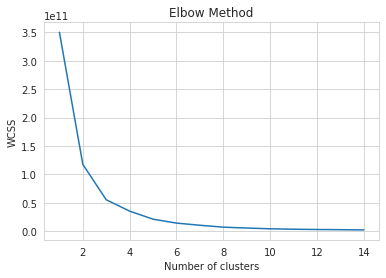

In [42]:
_ = get_kmeans_wcss(rfm, n_limit=15)

Elbow method suggests that ideal number of clusters would be 3 (knee point)

In [43]:
kmeans = KMeans(n_clusters=3, init = "k-means++", random_state=42)
clustered_cust = kmeans.fit_predict(rfm)

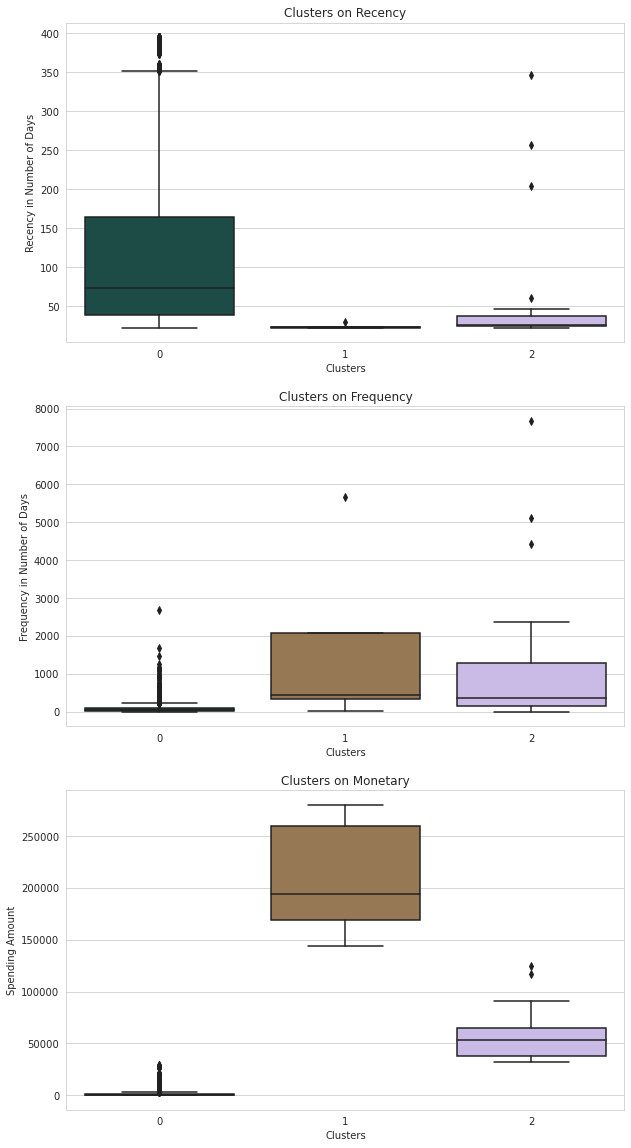

In [44]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,20))
sns.boxplot(clustered_cust,recent, palette="cubehelix",ax=ax[0])
ax[0].set(xlabel="Clusters", ylabel = "Recency in Number of Days")
ax[0].title.set_text('Clusters on Recency')
sns.boxplot(clustered_cust,frequent, palette="cubehelix",ax=ax[1])
ax[1].set(xlabel="Clusters", ylabel = "Frequency in Number of Days")
ax[1].title.set_text('Clusters on Frequency')
sns.boxplot(clustered_cust,monetary, palette="cubehelix",ax=ax[2])
ax[2].set(xlabel="Clusters", ylabel = "Spending Amount")
ax[2].title.set_text('Clusters on Monetary')

* RECENCY boxplot<br>
Cluster 0 have low recency, which is not appreciable. <br>
Cluster 1,2 are having high recency, suggesting that they are more prone to marketing<br>

* FREQUENCY boxplot<br>
Cluster 0 has low frequency, which means customers are not doing transactions frequently<br>
Cluster 1,2 are having better frequency, suggesting that they are more satisfied in general<br>

* MONETARY boxplot<br>
Cluster 0 has lowest value suggesting they are having lowest affordability<br>
Cluster 1 are heavy spenders<br>
Cluster 2 comes in middle<br>

In summary, <br>

| Clusters | Recency | Frequency | Monetary |
| --- | --- | --- | --- |
| 0 | Have not visited recently | Least frequent | Least spending |
| 1 | Most recently visited | Highest frequency | Spending Highest |
| 2 | Recently visited | Decent frequency | Decent Spending |

<br>
Now let us see customer counts by clusters

In [45]:
rfm['Clusters'] = clustered_cust
rfm.Clusters.value_counts()

0    4308
2      26
1       5
Name: Clusters, dtype: int64

**Segregation:** <br>
* Majority of customers,  ~96% belong to cluster 0 (Which is not good)
* Only ~1.14% of customers belong to cluster 1
* ~2.74% of customers belong to cluster 2


### Q. Can we take some initiatives based on the data to increase the sales? <a class="anchor" id="4.4"></a>

* **Inititative 1**: We noticed that not just revenue and sales increased in November and December, but number of new customers also increased during aforementioned period. It gives testifies that, November and December is a peak season. It would be wise to increase marketing during this tenure

* **Initiative 2**: POSTAL CHARGES and CARRIAGE CHARGES. Majority of transactions done in UK, Germany and in France is for Postage charges. Working with postal companies to reduce the postal charges can increase company’s revenue and Customer base

* **Initiative 3**: Coming up with loyalty program for cluster 1 and 2 category customers. It will appreciate customers for buying more products from the company

* **Initiative 4**: ~16 % of all transactions are cancelled. This might be due to poor transaction interface infrastructure. Upgrading technical foreground of the company might increase the customer engagement. 


### Q. Based on data can we avoid out of stock situations? <a class="anchor" id="4.5"></a>

We have huge variety of products (~4000 unique products) and in order to make them managable, it is important for us to segregate the products into categories

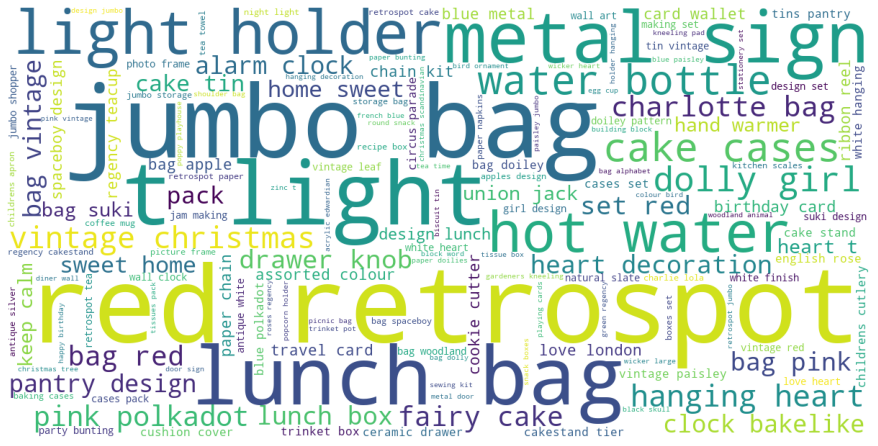

In [46]:
comment_words = '' 
stopwords = set(STOPWORDS) 

for val in df.ProductName: 
    
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1200, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

# plot the WordCloud image
plt.figure(figsize = (12, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 


#### Holiday Analysis
Let us see how holidays have impacted the sales figure

In [47]:
df['HolidaySeason'] = 0
df.loc[df['InvoiceDate'].dt.month.isin([9,10,11]), 'HolidaySeason'] = 1

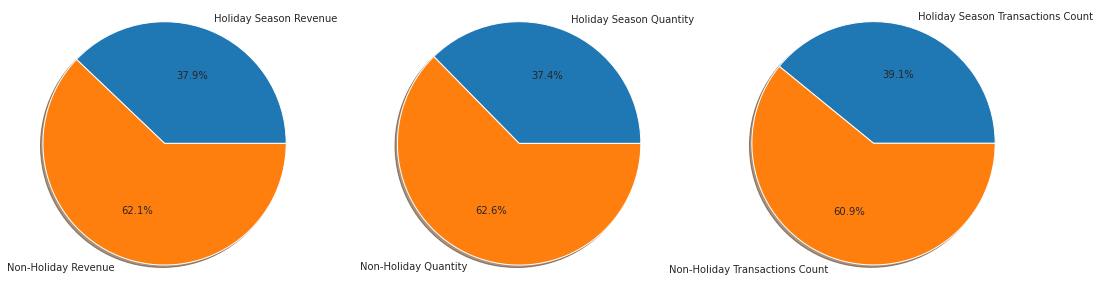

In [48]:
d = df[df['InvoiceDate'].dt.year==2011]
d['Transactions Count'] = 1
labels0 = ['Holiday Season Revenue', 'Non-Holiday Revenue']
sizes0 = [d[d['HolidaySeason']==1]['TotalPrice'].sum(),
         d[d['HolidaySeason']==0]['TotalPrice'].sum()
        ]

labels1 = ['Holiday Season Quantity', 'Non-Holiday Quantity']
sizes1 = [d[d['HolidaySeason']==1]['Quantity'].sum(),
         d[d['HolidaySeason']==0]['Quantity'].sum()
        ]

labels2 = ['Holiday Season Transactions Count', 'Non-Holiday Transactions Count']
sizes2 = [d[d['HolidaySeason']==1]['Transactions Count'].sum(),
         d[d['HolidaySeason']==0]['Transactions Count'].sum()
        ]

fig1, ax = plt.subplots(ncols=3,figsize=(18,5))
ax[0].pie(sizes0, labels=labels0, autopct='%1.1f%%', shadow=True)
ax[0].axis('equal')
ax[1].pie(sizes1, labels=labels1, autopct='%1.1f%%', shadow=True)
ax[1].axis('equal')
ax[2].pie(sizes2, labels=labels2, autopct='%1.1f%%', shadow=True)
ax[2].axis('equal')
plt.show()

It is safe to say that almost 37% sale (by revenue,quantity and transactions) occurs in Holiday season (Sep-Dec) 
#### Are there any products which are sold more during christmas season? <a class="anchor" id="4.5.1"></a>
We have already seen a surge in sale during holiday season. Are there any specific ```StockCode``` contributing to it? Let's figure it out.
We will segregate the products in two ways using count of seasonal and off-seasonal sale:<br>
1. Based on K-nn created groupings
2. Based on Qunatile Range groupings<br><br>
Let's see first KNN based groupings.<br>
LOGIC: Based on Seasonal and Off-Seasonal Counts for each ```StockCode```, we will create clusters called as ```ProductClusters``` and we will see how each cluster's sales have occurred during the whole year 2011

In [49]:
df['Transactions Count'] = 1
l1 = df[df['HolidaySeason']==1].groupby('StockCode')['Transactions Count'].sum()
l2 = df[df['HolidaySeason']==0].groupby('StockCode')['Transactions Count'].sum()
x = pd.DataFrame(data=[l1,l2]).T
x.columns = ['Season','Off-Season']
x = x.fillna(0)
x = x.reset_index()

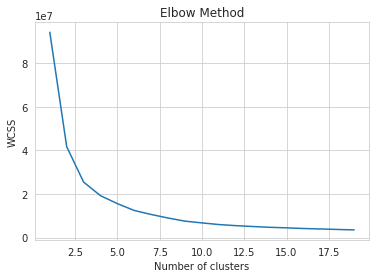

In [50]:
_ = get_kmeans_wcss(x[['Season','Off-Season']], n_limit=20)

In [51]:
kmeans = KMeans(n_clusters=10, init = "k-means++", random_state=100)
clustered_cust = kmeans.fit_predict(x[['Season','Off-Season']])
x['cluster'] = clustered_cust

Text(0, 0.5, 'Off-Season Counts')

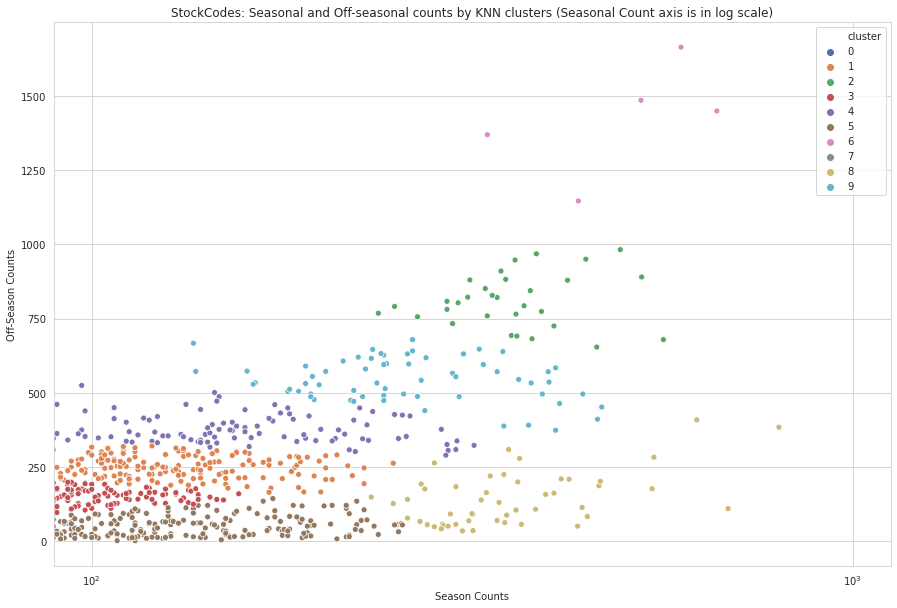

In [52]:
plt.figure(figsize=(15,10))
g1 = sns.scatterplot(x['Season'],x['Off-Season'],hue=x['cluster'],palette="deep")
g1.set_xscale("log")
plt.xlabel('Season Counts')
plt.title('StockCodes: Seasonal and Off-seasonal counts by KNN clusters (Seasonal Count axis is in log scale)')
plt.ylabel('Off-Season Counts')

Let's see what products are there in Cluster 8 (It has great sales during both season and off-season)

In [53]:
df[df['StockCode'].isin(x[x['cluster']==8]['index'])]['ProductName'].unique()

array(['HAND WARMER UNION JACK', 'HAND WARMER RED RETROSPOT',
       "PAPER CHAIN KIT 50'S CHRISTMAS ",
       'HOT WATER BOTTLE TEA AND SYMPATHY',
       'PAPER CHAIN KIT VINTAGE CHRISTMAS',
       'HAND WARMER SCOTTY DOG DESIGN', 'HAND WARMER OWL DESIGN',
       'HAND WARMER BIRD DESIGN', 'HOT WATER BOTTLE I AM SO POORLY',
       'ROTATING SILVER ANGELS T-LIGHT HLDR',
       'CHRISTMAS CRAFT TREE TOP ANGEL', 'CHRISTMAS CRAFT LITTLE FRIENDS',
       '60 CAKE CASES VINTAGE CHRISTMAS',
       'SET OF 20 VINTAGE CHRISTMAS NAPKINS',
       'CHRISTMAS CRAFT WHITE FAIRY ',
       'WOODEN HEART CHRISTMAS SCANDINAVIAN',
       'SET OF 6 RIBBONS VINTAGE CHRISTMAS',
       'WOODEN TREE CHRISTMAS SCANDINAVIAN',
       'WOODEN STAR CHRISTMAS SCANDINAVIAN', 'ZINC FOLKART SLEIGH BELLS',
       'RABBIT NIGHT LIGHT', 'JINGLE BELL HEART DECORATION',
       'SET OF 3 WOODEN HEART DECORATIONS',
       'SET OF 4 KNICK KNACK TINS DOILEY ', 'SMALL WHITE HEART OF WICKER',
       'SET OF 3 WOODEN STOCKING DE

Let's see Quantile based groupings.<br>
LOGIC: Based on Seasonal and Off-Seasonal Counts for each ```StockCode```, we will create clusters called as ```Q-Regions``` and we will see how each region's sales have occurred during the whole year 2011

| Quantile Region | Seasonal Sale (X-Axis) | Off-Seasonal Sale (Y-Axis) | Comment |
| --- | --- | --- | --- |
| 1 | High Sales | High Sales | Ever-green Products |
| 2 | Low and Moderate Sales | High Sales | Off-Seasonal Products (Day-to-day products) |
| 3 | Low and Moderate Sales | Low and Moderate Sales | Rarely and often used products |
| 4 | Low and Moderate Sales | High Sales | Seasonal Products/Giftings |

<br>
Note that because of choice of quantile point, distribution would be highly skewed towards Low and Moderate Sales. Reason of choosing such a high quantile is to segregate the Region-1 products effectively

In [54]:
QUANTILE = [0.90]
MAX_QUANTILE = [0.95]
MIN_QUANTILE = [0.15]
print(x['Season'].quantile(QUANTILE))
print(x['Off-Season'].quantile(QUANTILE))
x.loc[:,'Q-Region'] = 0
x.loc[(x['Season']>x['Season'].quantile(QUANTILE).values[0])&(x['Off-Season']>x['Off-Season'].quantile(QUANTILE).values[0]),'Q-Region'] = 1
x.loc[(x['Season']<=x['Season'].quantile(QUANTILE).values[0])&(x['Off-Season']>x['Off-Season'].quantile(QUANTILE).values[0]),'Q-Region'] = 2
x.loc[(x['Season']<=x['Season'].quantile(QUANTILE).values[0])&(x['Off-Season']<=x['Off-Season'].quantile(QUANTILE).values[0]),'Q-Region'] = 3
x.loc[(x['Season']>x['Season'].quantile(QUANTILE).values[0])&(x['Off-Season']<=x['Off-Season'].quantile(QUANTILE).values[0]),'Q-Region'] = 4

0.9    132.0
Name: Season, dtype: float64
0.9    215.0
Name: Off-Season, dtype: float64


Text(0, 0.5, 'Off-Season Counts')

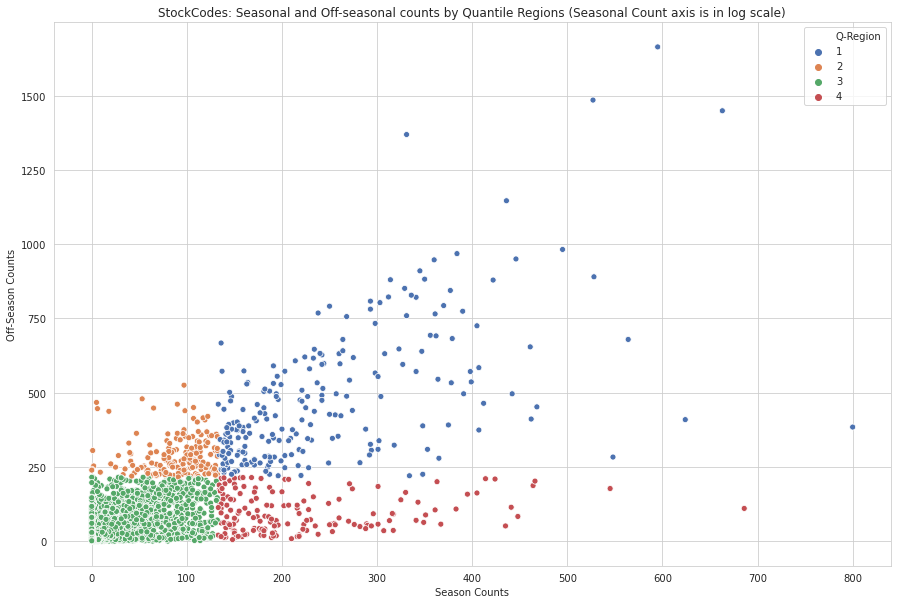

In [55]:
plt.figure(figsize=(15,10))
g1 = sns.scatterplot(x['Season'],x['Off-Season'],hue=x['Q-Region'],palette="deep")
# g1.set_xscale("log")
plt.title('StockCodes: Seasonal and Off-seasonal counts by Quantile Regions (Seasonal Count axis is in log scale)')
plt.xlabel('Season Counts')
plt.ylabel('Off-Season Counts')

In [56]:
df = df.merge(x,left_on=['StockCode'],right_on=['index']).drop(['index','Season','Off-Season'],axis=1).rename({'cluster':'ProductCluster'},axis=1)

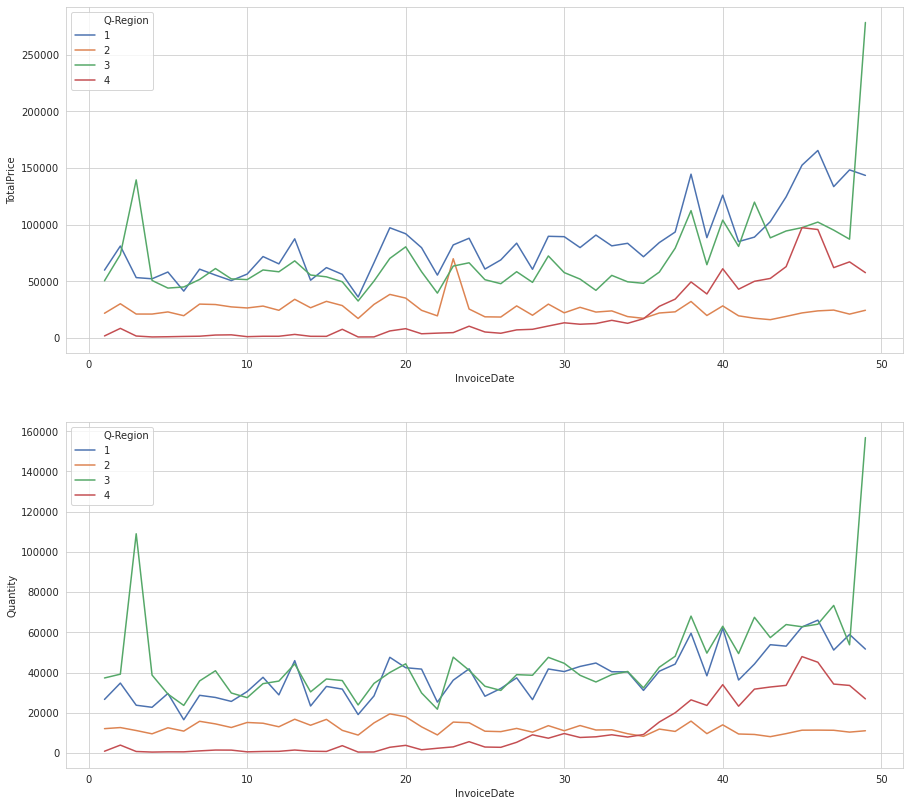

In [57]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,14))
ddf = df[(df['Quantity']>0)&(df["InvoiceDate"].dt.year==2011)]
d = df.groupby([ddf["InvoiceDate"].dt.week,df['Q-Region']]).agg({'TotalPrice':'sum',
                                                  'Quantity': 'sum',
                                                  'CustomerID': 'count'}).reset_index()
sns.lineplot(data=d,y='TotalPrice',x='InvoiceDate',hue='Q-Region',palette="deep",ax=ax[0])
sns.lineplot(data=d,y='Quantity',x='InvoiceDate',hue='Q-Region',palette="deep",ax=ax[1])
plt.show()

Let us see few products of each quantiles

In [58]:
Q1 = df[df['Q-Region']==1]
Q2 = df[df['Q-Region']==2]
Q3 = df[df['Q-Region']==3]
Q4 = df[df['Q-Region']==4]

In [59]:
Q1.groupby(['StockCode','ProductName'])[['UnitPrice','TotalPrice','Quantity']].sum().sort_values(by='UnitPrice',ascending=False).head(10)

,,UnitPrice,TotalPrice,Quantity
StockCode,ProductName,,,
DOT,DOTCOM POSTAGE,206248.77,206248.77,1708
POST,POSTAGE,34992.23,78101.88,6500
22423,REGENCY CAKESTAND 3 TIER,28065.76,174156.54,13809
47566,PARTY BUNTING,9850.68,99445.23,18287
22720,SET OF 3 CAKE TINS PANTRY DESIGN,8120.53,38108.89,7433
85066,CREAM SWEETHEART MINI CHEST,7497.46,22594.20,1784
85123A,WHITE HANGING HEART T-LIGHT HOLDER,7024.49,104462.75,41389
22624,IVORY KITCHEN SCALES,6727.86,16378.71,1910
22847,BREAD BIN DINER STYLE IVORY,6545.63,14389.34,896


In [60]:
Q2.groupby(['StockCode','ProductName'])[['UnitPrice','TotalPrice','Quantity']].sum().sort_values(by='UnitPrice',ascending=False).head(10)

,,UnitPrice,TotalPrice,Quantity
StockCode,ProductName,,,
22424,ENAMEL BREAD BIN CREAM,7216.03,12358.33,873
21843,RED RETROSPOT CAKE STAND,6820.69,21354.30,1949
22501,PICNIC BASKET WICKER LARGE,6408.71,19302.26,1565
22605,WOODEN CROQUET GARDEN SET,4867.47,11276.21,782
22502,PICNIC BASKET WICKER 60 PIECES,4800.89,51408.77,1945
22487,WHITE WOOD GARDEN PLANT LADDER,4663.66,7909.28,784
21621,VINTAGE UNION JACK BUNTING,4581.32,24525.83,2357
22844,VINTAGE CREAM DOG FOOD CONTAINER,4526.56,9661.32,1003
21524,DOORMAT SPOTTY HOME SWEET HOME,4427.39,13572.06,1752


In [61]:
Q3.groupby(['StockCode','ProductName'])[['UnitPrice','TotalPrice','Quantity']].sum().sort_values(by='UnitPrice',ascending=False).head(10)

,,UnitPrice,TotalPrice,Quantity
StockCode,ProductName,,,
M,Manual,74098.73,77750.27,6990
AMAZONFEE,AMAZON FEE,13761.09,13761.09,2
C2,CARRIAGE,7033.00,7051.00,292
84078A,SET/4 WHITE RETRO STORAGE CUBES,7011.00,16363.30,415
22655,VINTAGE RED KITCHEN CABINET,5450.00,8125.00,49
22846,BREAD BIN DINER STYLE RED,4920.45,10676.62,665
22826,LOVE SEAT ANTIQUE WHITE METAL,4675.00,6210.00,58
22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD,4110.00,5415.00,31
21340,CLASSIC METAL BIRDCAGE PLANT HOLDER,3894.65,11300.02,975


In [62]:
Q4.groupby(['StockCode','ProductName'])[['UnitPrice','TotalPrice','Quantity']].sum().sort_values(by='UnitPrice',ascending=False).head(10)

,,UnitPrice,TotalPrice,Quantity
StockCode,ProductName,,,
23355,HOT WATER BOTTLE KEEP CALM,4196.16,28718.80,5816
22114,HOT WATER BOTTLE TEA AND SYMPATHY,3245.81,32973.44,5666
22941,CHRISTMAS LIGHTS 10 REINDEER,3098.46,13795.92,1670
23356,LOVE HOT WATER BOTTLE,3015.93,13334.32,2359
23397,FOOT STOOL HOME SWEET HOME,2511.53,5097.65,480
85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,2447.73,10910.61,1359
23080,RED METAL BOX TOP SECRET,2437.55,9117.62,1074
23108,SET OF 10 LED DOLLY LIGHTS,2413.28,13290.52,2219
23313,VINTAGE CHRISTMAS BUNTING,2263.84,15798.66,2990


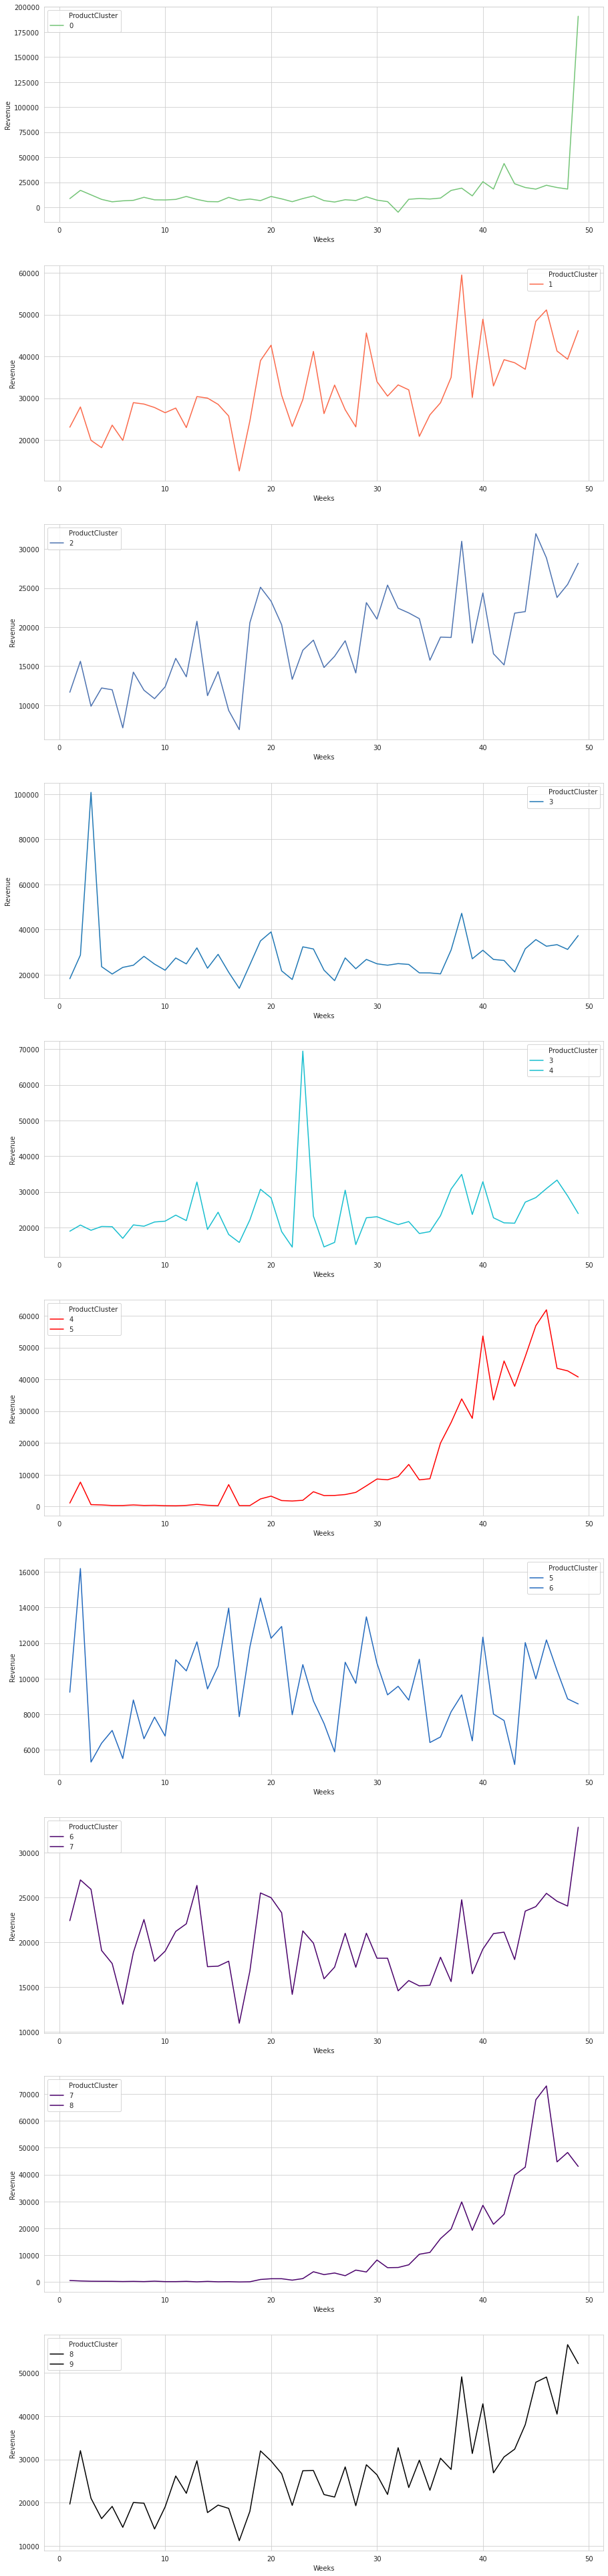

In [63]:
fig, ax = plt.subplots(nrows=10, ncols=1,figsize=(15,70))
ddf = df[(df['Quantity']>0)&(df["InvoiceDate"].dt.year==2011)]
d = df.groupby([ddf["InvoiceDate"].dt.week,df['ProductCluster']]).agg({'TotalPrice':'sum',
                                                  'Quantity': 'sum',
                                                  'CustomerID': 'count'}).reset_index()
d = d.rename({'TotalPrice':'Revenue','InvoiceDate':'Weeks'},axis=1)
sns.lineplot(data=d[d['ProductCluster']==0],y='Revenue',x='Weeks',hue='ProductCluster',palette="Greens",ax=ax[0])
sns.lineplot(data=d[d['ProductCluster']==1],y='Revenue',x='Weeks',hue='ProductCluster',palette="Reds",ax=ax[1])
sns.lineplot(data=d[d['ProductCluster']==2],y='Revenue',x='Weeks',hue='ProductCluster',palette="deep",ax=ax[2])
sns.lineplot(data=d[d['ProductCluster']==3],y='Revenue',x='Weeks',hue='ProductCluster',palette="tab10",ax=ax[3])
sns.lineplot(data=d[d['ProductCluster']==4],y='Revenue',x='Weeks',hue='ProductCluster',palette="tab10_r",ax=ax[4])
sns.lineplot(data=d[d['ProductCluster']==5],y='Revenue',x='Weeks',hue='ProductCluster',palette="prism",ax=ax[5])
sns.lineplot(data=d[d['ProductCluster']==6],y='Revenue',x='Weeks',hue='ProductCluster',palette="vlag",ax=ax[6])
sns.lineplot(data=d[d['ProductCluster']==7],y='Revenue',x='Weeks',hue='ProductCluster',palette="RdPu_r",ax=ax[7])
sns.lineplot(data=d[d['ProductCluster']==8],y='Revenue',x='Weeks',hue='ProductCluster',palette="RdPu_r",ax=ax[8])
sns.lineplot(data=d[d['ProductCluster']==9],y='Revenue',x='Weeks',hue='ProductCluster',palette="CMRmap",ax=ax[9])
# sns.lineplot(data=d,y='Quantity',x='InvoiceDate',hue='ProductCluster',palette="deep",ax=ax[1])
plt.show()

We can see certain category of products get a sale spike during holiday seasons and during year end. For example products in cluster 7,8 and 1<br>
Moreover there is a sudden demand on Product cluster 3 in the beginning of the year

### Q. What kind of Customers are buying from us? <a class="anchor" id="4.6"></a>
### Understanding Customer's Purchase Pattern <a class="anchor" id="4.6.1"></a>
Now, we can also analyse the customer's purchasing pattern which can give us some insights about the customers. We can do this by using **Association Rule Learning** or ARL. These algorithms answer questions like "People who bought this also bought..." or "Customers tend to buy A and B together more often". We will use one of the famous ARL, Apriori Algorithm
<br><br>
But first, let us segregate transactions in baskets based on countries (since, creating a single basket of all the transactions would be resource intensive. Also, for the same reason, we would be avoiding creation of United Kingdom's basket)

In [64]:
basket_Germany = df[df['Country']=="Germany"].groupby(['InvoiceNo', 'ProductName'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket_EIRE = df[df['Country']=="EIRE"].groupby(['InvoiceNo', 'ProductName'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket_UK = df[df['Country']=="UK"].groupby(['InvoiceNo', 'ProductName'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket_France = df[df['Country']=="France"].groupby(['InvoiceNo', 'ProductName'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

In [65]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_Germany.drop('POSTAGE',axis=1,inplace=True)
basket_France.drop('POSTAGE',axis=1,inplace=True)

basket_Germany = basket_Germany.applymap(encode_units)
basket_EIRE = basket_EIRE.applymap(encode_units)
basket_UK = basket_UK.applymap(encode_units)
basket_France = basket_France.applymap(encode_units)

Before heading it is important to understand few terminology,<br>
First, 
### Support:
Support of an itemset X is propotion of transaction in the data in which X appears. It shows the **popularity** of X i.e. <br>
##### $$\text{Support(X)} = \frac{\text{Number of Transactions in which X appears}}{\text{Total Number of Transactions}} = \frac{freq(X)}{N}$$
in our case, for a given rule A->B (in other words if A is bought, B is also bought) 
##### $$\text{Support(A,B)} = \frac{\text{Number of Transactions in which A and B both appears}}{\text{Total Number of Transactions}} = \frac{freq(A,B)}{N}$$

### Confidence:
Confidence for a given rule A->B is defined as frequency of A and B together in a basket divided by frequency of A:
##### $$\text{Confidence} = \frac{freq(A,B)}{freq(A)}$$
It shows the **likelihood** of item B being purchased when A is purchased. We must also take its drawback into consideration viz. it takes popularity of A in consideration. If product B is also equally popular as A then there will be a higher probability that a transaction containing A will also contain B thus increasing the confidence

### Lift:
Lift for a given rule A->B is defined as
##### $$\text{Lift} = \frac{Support(A,B)}{Support(A) * Support(B))}$$
This signifies the likelihood of the itemset B being purchased when item A is purchased while taking into account the popularity of B. If the value of lift is greater than 1, it means that the itemset B is likely to be bought with itemset A, while a value less than 1 implies that itemset B is unlikely to be bought if the itemset A is bought.

### Conviction:
Conviction for a given rule A->B is defined as
##### $$\text{Conviction(A,B)} = \frac{1-Support(B)}{1-Confidence(A,B)}$$
Say, the conviction value of 1.32 means that the rule A->B would be incorrect 32% more often if the association between A and B was an accidental chance.


### Leverage:
Leverage for a given rule A->B is defined as
##### $$\text{Leverage(A,B)} = P(A and B) - P(A)P(B)$$

" Leverage measures the difference of A and B appearing together in the data set and what would be expected if A and B where statistically dependent. The rational in a sales setting is to find out how many more units (items A and B together) are sold than expected from the independent sells. Using min. leverage thresholds at the same time incorporates an implicit frequency constraint. E.g., for setting a min. leverage thresholds to 0.01% (corresponds to 10 occurrence in a data set with 100,000 transactions) one first can use an algorithm to find all itemsets with min. support of 0.01% and then filter the found item sets using the leverage constraint. Because of this property leverage also can suffer from the rare item problem. "

Here is a good read on Apriori Algorithm Basics: <br>
https://michael.hahsler.net/research/recommender/associationrules.html<br>
https://www.hackerearth.com/blog/developers/beginners-tutorial-apriori-algorithm-data-mining-r-implementation/

In [66]:
frequent_itemsets = apriori(basket_France, min_support=0.07, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values(['lift','support'],ascending=False).reset_index(drop=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
1,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
2,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED ),0.102041,0.094388,0.073980,0.725000,7.681081,0.064348,3.293135
3,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE PINK),0.094388,0.102041,0.073980,0.783784,7.681081,0.064348,4.153061
4,(SET/6 RED SPOTTY PAPER PLATES),"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",0.127551,0.102041,0.099490,0.780000,7.644000,0.086474,4.081633
5,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.102041,0.127551,0.099490,0.975000,7.644000,0.086474,34.897959
6,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.096939,0.102041,0.073980,0.763158,7.478947,0.064088,3.791383
7,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102041,0.096939,0.073980,0.725000,7.478947,0.064088,3.283859
8,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",(SET/6 RED SPOTTY PAPER CUPS),0.102041,0.137755,0.099490,0.975000,7.077778,0.085433,34.489796
9,(SET/6 RED SPOTTY PAPER CUPS),"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",0.137755,0.102041,0.099490,0.722222,7.077778,0.085433,3.232653


In [67]:
frequent_itemsets = apriori(basket_Germany, min_support=0.07, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values(['lift','support'],ascending=False).reset_index(drop=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ROUND SNACK BOXES SET OF 4 FRUITS ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.157549,0.245077,0.131291,0.833333,3.400298,0.092679,4.529540
1,(ROUND SNACK BOXES SET OF4 WOODLAND ),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.245077,0.157549,0.131291,0.535714,3.400298,0.092679,1.814509
2,(SPACEBOY LUNCH BOX ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.102845,0.245077,0.070022,0.680851,2.778116,0.044817,2.365427
3,(ROUND SNACK BOXES SET OF4 WOODLAND ),(SPACEBOY LUNCH BOX ),0.245077,0.102845,0.070022,0.285714,2.778116,0.044817,1.256018
4,(ROUND SNACK BOXES SET OF4 WOODLAND ),(PLASTERS IN TIN WOODLAND ANIMALS),0.245077,0.137856,0.074398,0.303571,2.202098,0.040613,1.237951
5,(PLASTERS IN TIN WOODLAND ANIMALS),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.137856,0.245077,0.074398,0.539683,2.202098,0.040613,1.640006


Hmm... It is interesting to note that in France, (ALARM CLOCK BAKELIKE RED ) and (ALARM CLOCK BAKELIKE GREEN) are very frequently bought together. Similarly, (ALARM CLOCK BAKELIKE RED ) and (ALARM CLOCK BAKELIKE PINK) are often bought together.
Also, in Germany, (ROUND SNACK BOXES SET OF 4 FRUITS ) and (ROUND SNACK BOXES SET OF4 WOODLAND ) are most frequently bought together.
It is worth noting that all of these items are **essencially the same, i.e. ALARM CLOCK and SNACK BOXES**. 

##### This behavior in purchasing pattern shows us that the majority of transactions done by the Customers are more likely to be Wholesale Retailers than some individuals. 

# *That's All Folks!*